In [40]:
import sys
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, zscore, rankdata
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import from_networkx, add_self_loops, to_undirected
from tqdm import tqdm
from torch.utils.data import Dataset
from torch_geometric.data import Dataset
from torch.nn import (BatchNorm1d, Dropout, Linear,
                      Module)
from torch_geometric.nn import (GCNConv, GATConv, SAGEConv, GlobalAttention,
                                global_mean_pool, ChebConv, MessagePassing)



In [41]:
lines = []
with open('/Users/leopoldstevens/Desktop/EEG_decoder/EP1.01.txt', 'r') as file:
    for line in file:
        lines.append(line)
print(len(lines))

910476


In [42]:
print(lines[0])
print(lines[1])
print(lines[2])
print(lines[3])
print(lines[4])

67635	67635	EP	AF3	6	260	4395.384615,4382.564102,4377.435897,4387.179487,4395.897435,4398.461538,4396.923076,4391.794871,4391.282051,4395.897435,4398.974358,4396.410256,4392.820512,4392.820512,4395.384615,4398.974358,4394.358974,4381.538461,4376.410256,4383.589743,4387.179487,4388.717948,4397.948717,4401.538461,4397.948717,4398.974358,4398.974358,4395.897435,4396.923076,4398.461538,4397.948717,4396.410256,4391.794871,4389.743589,4389.743589,4385.641025,4387.692307,4393.846153,4389.743589,4381.025641,4377.948717,4378.461538,4377.435897,4385.128205,4393.333333,4389.230769,4382.564102,4378.974358,4375.384615,4378.461538,4386.153846,4389.230769,4393.846153,4390.256410,4374.871794,4367.692307,4374.871794,4384.615384,4390.769230,4394.358974,4390.769230,4382.051282,4381.025641,4385.641025,4376.923076,4365.641025,4373.333333,4377.948717,4365.128205,4363.589743,4375.897435,4374.358974,4368.205128,4373.333333,4378.461538,4375.897435,4374.358974,4376.410256,4377.435897,4376.410256,4370.256410,437

In [43]:
split_ = lines[0].split()
for i in range(len(split_)):
    print(i, split_[i])

0 67635
1 67635
2 EP
3 AF3
4 6
5 260
6 4395.384615,4382.564102,4377.435897,4387.179487,4395.897435,4398.461538,4396.923076,4391.794871,4391.282051,4395.897435,4398.974358,4396.410256,4392.820512,4392.820512,4395.384615,4398.974358,4394.358974,4381.538461,4376.410256,4383.589743,4387.179487,4388.717948,4397.948717,4401.538461,4397.948717,4398.974358,4398.974358,4395.897435,4396.923076,4398.461538,4397.948717,4396.410256,4391.794871,4389.743589,4389.743589,4385.641025,4387.692307,4393.846153,4389.743589,4381.025641,4377.948717,4378.461538,4377.435897,4385.128205,4393.333333,4389.230769,4382.564102,4378.974358,4375.384615,4378.461538,4386.153846,4389.230769,4393.846153,4390.256410,4374.871794,4367.692307,4374.871794,4384.615384,4390.769230,4394.358974,4390.769230,4382.051282,4381.025641,4385.641025,4376.923076,4365.641025,4373.333333,4377.948717,4365.128205,4363.589743,4375.897435,4374.358974,4368.205128,4373.333333,4378.461538,4375.897435,4374.358974,4376.410256,4377.435897,4376.410256,4

In [44]:
event = []
digit = []
pos = []
data = []
line_counter = 0

data_df = pd.DataFrame(columns=['event', 'digit', 'pos', 'data'])

for line in tqdm(lines):
    if line_counter<14_000:
        split_line = line.split()
        event.append(split_line[1])
        digit.append(split_line[4])
        pos.append(split_line[3])
        data.append(split_line[6])
        line_counter+=1

data_df['event'] = event
data_df['digit'] = digit
data_df['pos'] = pos
data_df['data'] = data

num_events = data_df['event'].unique()
print(len(num_events))

del lines, event, digit, pos, data, num_events

print(data_df.head())
print(data_df.shape)

  0%|          | 0/910476 [00:00<?, ?it/s]

100%|██████████| 910476/910476 [00:15<00:00, 60189.19it/s]


1000
   event digit  pos                                               data
0  67635     6  AF3  4395.384615,4382.564102,4377.435897,4387.17948...
1  67635     6   F7  4489.230769,4475.384615,4474.358974,4486.66666...
2  67635     6   F3  4538.461538,4528.717948,4524.615384,4526.15384...
3  67635     6  FC5  4207.692307,4205.641025,4200.512820,4194.35897...
4  67635     6   T7  4497.948717,4498.461538,4494.871794,4497.94871...
(14000, 4)


In [45]:
def process_data(x):
    data_list = [float(i) for i in x.split(',')]
    if len(data_list) < 240:
        return None
    return data_list[:240]

In [46]:
print(data_df['data'].values)

['4395.384615,4382.564102,4377.435897,4387.179487,4395.897435,4398.461538,4396.923076,4391.794871,4391.282051,4395.897435,4398.974358,4396.410256,4392.820512,4392.820512,4395.384615,4398.974358,4394.358974,4381.538461,4376.410256,4383.589743,4387.179487,4388.717948,4397.948717,4401.538461,4397.948717,4398.974358,4398.974358,4395.897435,4396.923076,4398.461538,4397.948717,4396.410256,4391.794871,4389.743589,4389.743589,4385.641025,4387.692307,4393.846153,4389.743589,4381.025641,4377.948717,4378.461538,4377.435897,4385.128205,4393.333333,4389.230769,4382.564102,4378.974358,4375.384615,4378.461538,4386.153846,4389.230769,4393.846153,4390.256410,4374.871794,4367.692307,4374.871794,4384.615384,4390.769230,4394.358974,4390.769230,4382.051282,4381.025641,4385.641025,4376.923076,4365.641025,4373.333333,4377.948717,4365.128205,4363.589743,4375.897435,4374.358974,4368.205128,4373.333333,4378.461538,4375.897435,4374.358974,4376.410256,4377.435897,4376.410256,4370.256410,4370.769230,4380.000000,43

In [47]:
data_df['data'] = data_df['data'].apply(process_data)
data_df = data_df.dropna(subset=['data'])

data_df['event'] = data_df['event'].apply(float)
data_df['digit'] = data_df['digit'].apply(float)
data_df['digit'] = data_df['digit'].apply(lambda x: 10 if x == -1 else x)

# scaler = StandardScaler()
# data_df['data'] = data_df['data'].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1, 1)).flatten())

# all_data = np.concatenate(data_df['data'].values)
# all_data_reshaped = all_data.reshape(-1, 1)
# scaler = StandardScaler()
# scaler.fit(all_data_reshaped)
# data_df['data'] = data_df['data'].apply(lambda x: scaler.transform(np.array(x).reshape(-1, 1)).flatten())

all_data = np.concatenate(data_df['data'].values)
all_data_reshaped = all_data.reshape(-1, 1)
scaler = MinMaxScaler()
scaler.fit(all_data_reshaped)
data_df['data'] = data_df['data'].apply(lambda x: scaler.transform(np.array(x).reshape(-1, 1)).flatten())


# data_df.to_csv('data_df.csv')

print(data_df.head(28))
print(data_df.shape)
del all_data


      event  digit  pos                                               data
0   67635.0    6.0  AF3  [0.6188769412287869, 0.6129032254908082, 0.610...
1   67635.0    6.0   F7  [0.6626045398902891, 0.6561529269119102, 0.655...
2   67635.0    6.0   F3  [0.6855436078954533, 0.6810035838786759, 0.679...
3   67635.0    6.0  FC5  [0.5314217439057825, 0.5304659494249817, 0.528...
4   67635.0    6.0   T7  [0.6666666662007168, 0.6669056150538919, 0.665...
5   67635.0    6.0   P7  [0.5292712065569556, 0.524492233687003, 0.5254...
6   67635.0    6.0   O1  [0.5292712065569556, 0.5247311825401779, 0.525...
7   67635.0    6.0   O2  [0.5416965348073637, 0.535722819069385, 0.5311...
8   67635.0    6.0   P8  [0.5491039422665434, 0.5448028671029408, 0.536...
9   67635.0    6.0   T8  [0.6707287929770944, 0.6681003583878675, 0.666...
10  67635.0    6.0  FC6  [0.5407407403265632, 0.5350059734417594, 0.532...
11  67635.0    6.0   F4  [0.7524492234152957, 0.7455197131965161, 0.743...
12  67635.0    6.0   F8  

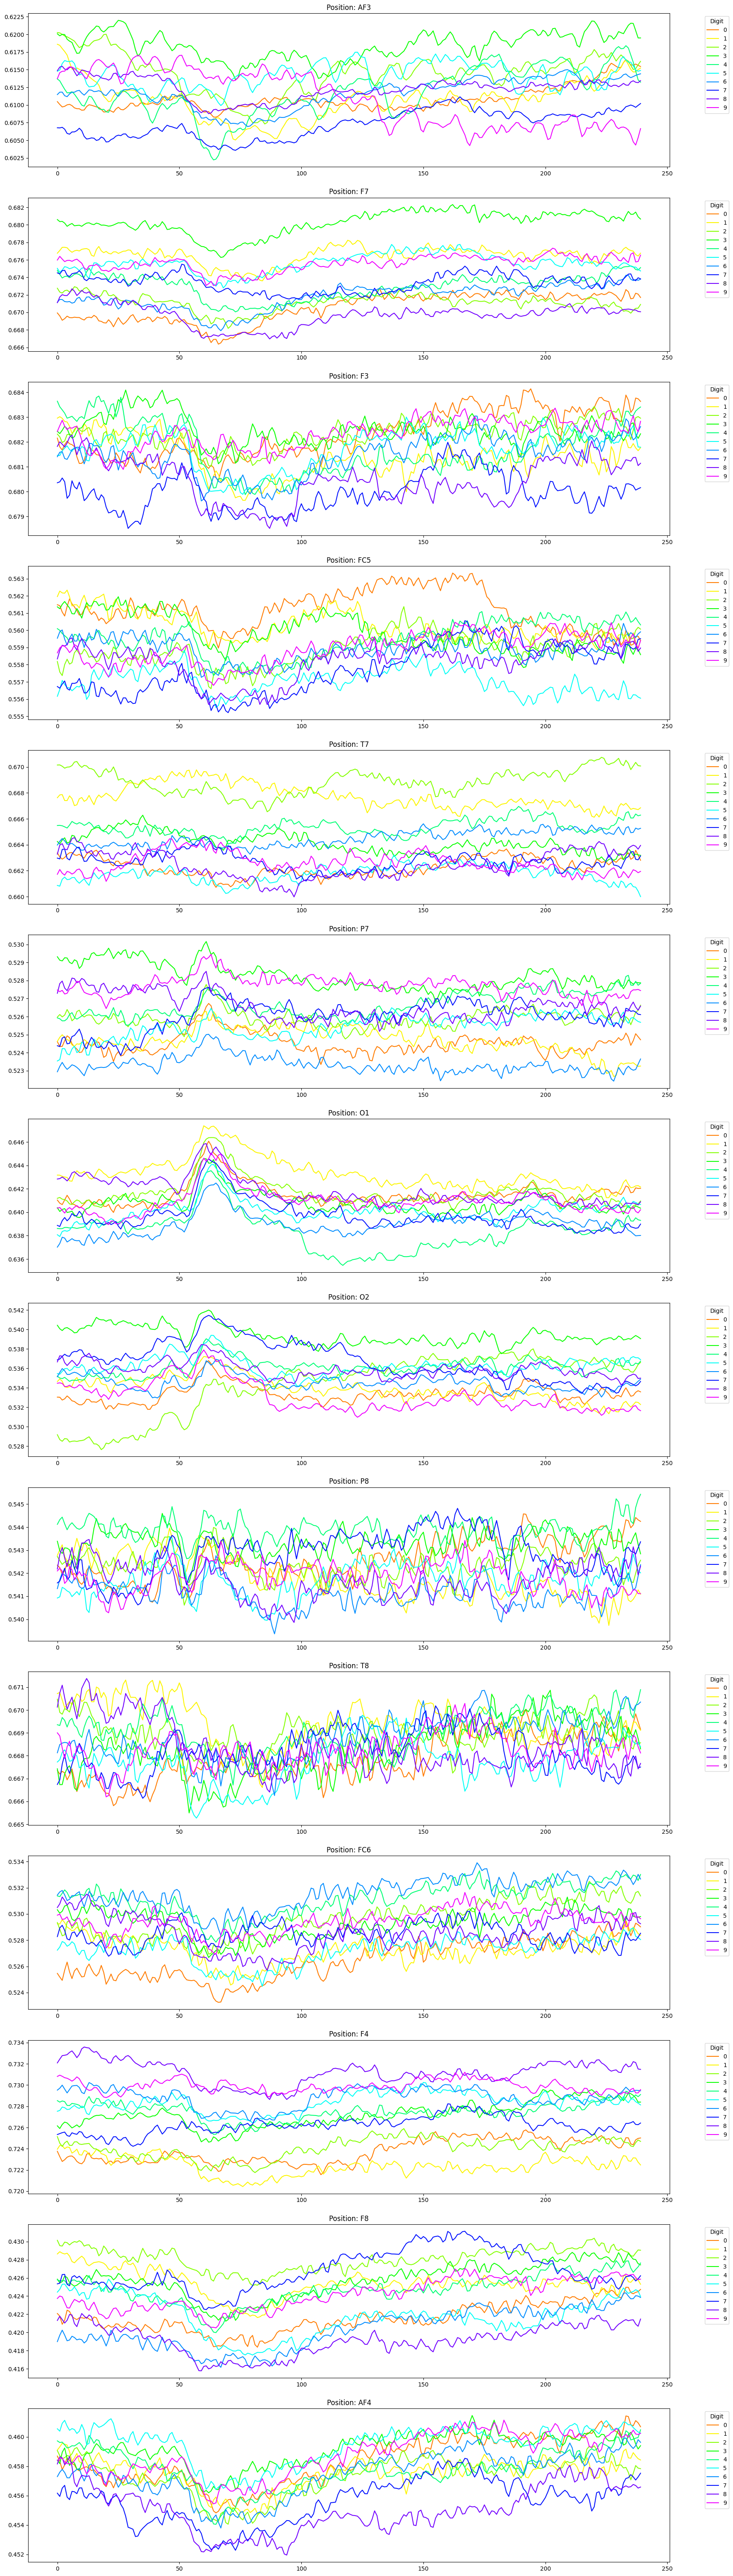

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data_df is your DataFrame

# Group by position and digit, then calculate the mean of data series
grouped_data = data_df.groupby(['pos', 'digit']).apply(lambda x: pd.DataFrame(x['data'].tolist()).mean().tolist())

n_subplots = len(data_df['pos'].unique())
fig, axes = plt.subplots(nrows=n_subplots, ncols=1, figsize=(20, 80))

# Create a color palette with 11 distinct colors
palette = sns.color_palette("hsv", 11)

for i, pos in enumerate(data_df['pos'].unique()):
    pos_group = grouped_data.xs(pos)
    for digit, data_series in pos_group.iteritems():
        sns.lineplot(x=range(len(data_series)), y=data_series, ax=axes[i], color=palette[int(digit)], label=int(digit))

    axes[i].set_title(f'Position: {pos}')
    axes[i].legend(title="Digit", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [49]:
pos_values = data_df['pos'].unique()
print(pos_values)
data_lengths = data_df['data'].apply(len)
unique_lengths = data_lengths.unique()
print(unique_lengths)
del data_lengths

['AF3' 'F7' 'F3' 'FC5' 'T7' 'P7' 'O1' 'O2' 'P8' 'T8' 'FC6' 'F4' 'F8' 'AF4']
[240]


In [50]:
coordinates = {
    'AF3': {'phi': (129.9+89.7)/2,
            'theta': (52.2+41.0)/2},
    'F7': {'phi': 137.2,
            'theta': 83.1},
    'F3': {'phi': 129.9,
            'theta': 52.2},
    'FC5': {'phi': (137.2+129.9+173.9+180)/4 ,
            'theta': (83.1+52.2+95+45.2/4)},
    'T7': {'phi': 173.9,
            'theta': 95.0},
    'P7': {'phi': 216.1,
            'theta': 92.9},
    'O1': {'phi': 250.6,
            'theta': 89.2},
    'O2': {'phi': 287.5,
            'theta': 90.1},
    'P8': {'phi': 322.7,
            'theta': 94.9},
    'T8': {'phi': 3.2,
            'theta': 95.8},
    'FC6': {'phi': (-1.0+3.2+40.3+49.8)/4,
            'theta':(46.0+95.8+84.1+53.6)/4 },
    'F4': {'phi': 49.8,
            'theta': 53.6},
    'F8': {'phi': 40.3,
            'theta': 84.1},
    'AF4': {'phi': (89.7+49.8)/2,
            'theta': (41.0+53.6)/2}
}

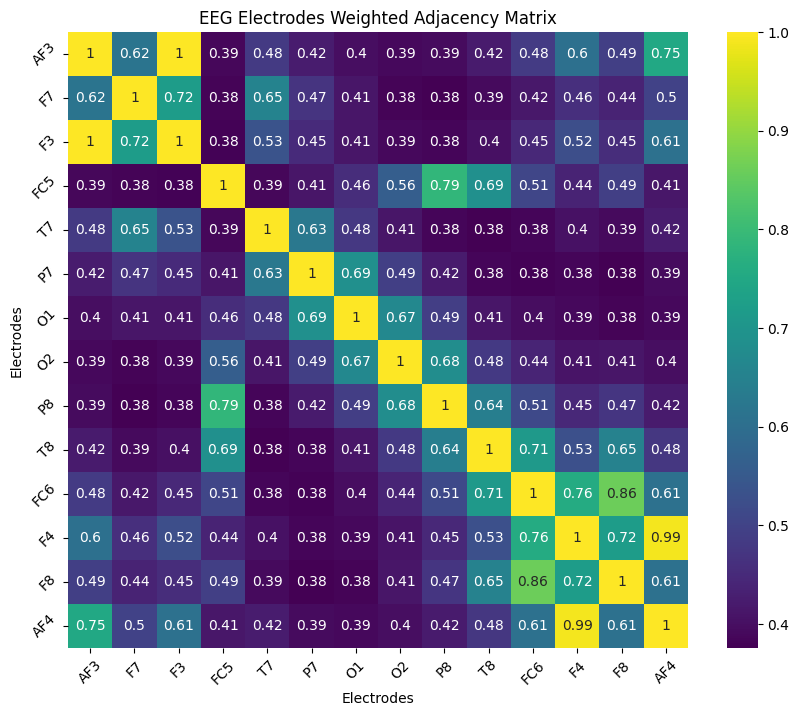

In [51]:
def spherical_to_cartesian(phi, theta):
    phi_rad = np.radians(phi)
    theta_rad = np.radians(theta)
    x = np.cos(phi_rad) * np.sin(theta_rad)
    y = np.sin(phi_rad) * np.sin(theta_rad)
    z = np.cos(theta_rad)
    return x, y, z

adjacency_matrix = np.zeros((len(coordinates), len(coordinates)))

for i, (coord_i, values_i) in enumerate(coordinates.items()):
    x_i, y_i, z_i = spherical_to_cartesian(values_i['phi'], values_i['theta'])
    for j, (coord_j, values_j) in enumerate(coordinates.items()):
        if i != j:
            x_j, y_j, z_j = spherical_to_cartesian(values_j['phi'], values_j['theta'])
            d = np.sqrt((x_j - x_i) ** 2 + (y_j - y_i) ** 2 + (z_j - z_i) ** 2)
            w = 1 / np.sqrt(d)
            adjacency_matrix[i, j] = w

max_weight = adjacency_matrix.max()
adjacency_matrix[adjacency_matrix > 0] /= max_weight

np.fill_diagonal(adjacency_matrix, 1)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(adjacency_matrix, annot=True, cmap='viridis', ax=ax)

plt.title('EEG Electrodes Weighted Adjacency Matrix')
plt.xlabel('Electrodes')
plt.ylabel('Electrodes')
plt.xticks(ticks=np.arange(len(coordinates)) + 0.5, labels=list(coordinates.keys()), rotation=45)
plt.yticks(ticks=np.arange(len(coordinates)) + 0.5, labels=list(coordinates.keys()), rotation=45)

plt.show()


In [52]:
def calculate_weights(coordinates):

    num_nodes = len(coordinates)
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    for i, coord_i in enumerate(coordinates.keys()):
        values_i = coordinates[coord_i]
        x_i, y_i, z_i = spherical_to_cartesian(values_i['phi'], values_i['theta'])
        for j, coord_j in enumerate(coordinates.keys()):
            if i != j:
                values_j = coordinates[coord_j]
                x_j, y_j, z_j = spherical_to_cartesian(values_j['phi'], values_j['theta'])
                d = np.sqrt((x_j - x_i) ** 2 + (y_j - y_i) ** 2 + (z_j - z_i) ** 2)
                w = 1 / d
                adjacency_matrix[i, j] = w

    max_weight = adjacency_matrix.max()
    adjacency_matrix[adjacency_matrix > 0] /= max_weight
    np.fill_diagonal(adjacency_matrix, 1)

    return adjacency_matrix



In [53]:
class EEGDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.unique_events = dataframe['event'].unique()

    def __len__(self):
        return len(self.unique_events)

    def __getitem__(self, idx):
        event_id = self.unique_events[idx]
        event_data = self.dataframe[self.dataframe['event'] == event_id]
        x = np.array([row.data for row in event_data.itertuples(index=False)])
        x = torch.tensor(x, dtype=torch.float)
        y = event_data.iloc[0]['digit']
        return x, y


In [54]:
from torch.utils.data import Subset

def custom_train_test_split(dataset, test_size=0.2, random_state=42):
    np.random.seed(random_state)

    indices = np.arange(len(dataset))
    print(indices.size)
    np.random.shuffle(indices)

    split_idx = int(len(dataset) * (1 - test_size))
    print(split_idx)

    train_indices, test_indices = indices[:split_idx], indices[split_idx:]

    print('split done')

    train_dataset = Subset(dataset, train_indices)
    print(train_dataset)
    test_dataset = Subset(dataset, test_indices)
    print(test_dataset)

    return train_dataset, test_dataset

In [55]:
dataset = EEGDataset(data_df)
print(dataset[0])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                        key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, size))

train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

del data_df

(tensor([[0.6189, 0.6129, 0.6105,  ..., 0.6148, 0.6177, 0.6179],
        [0.6626, 0.6562, 0.6557,  ..., 0.6695, 0.6719, 0.6698],
        [0.6855, 0.6810, 0.6791,  ..., 0.6772, 0.6808, 0.6810],
        ...,
        [0.7524, 0.7455, 0.7431,  ..., 0.7307, 0.7341, 0.7352],
        [0.4296, 0.4270, 0.4289,  ..., 0.4378, 0.4387, 0.4368],
        [0.4712, 0.4638, 0.4607,  ..., 0.4597, 0.4616, 0.4664]]), 6.0)
cpu
                       data_df: 29726032
                  grouped_data:   277404
                     pos_group:    19792
                 train_dataset:     6936
                          line:     3149
                          _i39:     2889
                          _i18:     2848
                   data_series:     1976
              adjacency_matrix:     1696
                  MinMaxScaler:     1688


In [73]:
class CustomLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.5):
        super(CustomLSTM, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(len(hidden_dims)):
            input_size = input_dim if i == 0 else hidden_dims[i-1]
            self.layers.append(nn.LSTM(input_size, hidden_dims[i], num_layers=1, batch_first=True, dropout=dropout_rate))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dims[i]))
            self.fc = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, x):
        for i, (layer, bn) in enumerate(zip(self.layers, self.batch_norms)):
            x, _ = layer(x)
            x = x.permute(0, 2, 1)  
            x = bn(x)
            x = x.permute(0, 2, 1)  
            
        x = x[:, -1, :]
        x = self.fc(x)
        return x


cpu


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Loss: 2.439187214924739, Train Accuracy: 0.11


  2%|▏         | 1/50 [00:06<05:16,  6.46s/it]

Test Loss: 2.405478136880057, Test Accuracy: 0.08
Epoch 2/50, Loss: 2.3490526492779074, Train Accuracy: 0.115


  4%|▍         | 2/50 [00:12<04:54,  6.13s/it]

Test Loss: 2.3564581189836775, Test Accuracy: 0.085
Epoch 3/50, Loss: 2.325809460419875, Train Accuracy: 0.10125


  6%|▌         | 3/50 [00:18<04:50,  6.18s/it]

Test Loss: 2.3291328634534563, Test Accuracy: 0.1
Epoch 4/50, Loss: 2.322854628929725, Train Accuracy: 0.1175


  8%|▊         | 4/50 [00:29<06:18,  8.23s/it]

Test Loss: 2.3247468130929128, Test Accuracy: 0.09
Epoch 5/50, Loss: 2.311308420621432, Train Accuracy: 0.11


 10%|█         | 5/50 [00:37<06:05,  8.12s/it]

Test Loss: 2.311122144971575, Test Accuracy: 0.115
Epoch 6/50, Loss: 2.306364811383761, Train Accuracy: 0.1175


 12%|█▏        | 6/50 [00:44<05:35,  7.62s/it]

Test Loss: 2.3304826532091414, Test Accuracy: 0.075
Epoch 7/50, Loss: 2.3122889812176046, Train Accuracy: 0.1125


 14%|█▍        | 7/50 [00:51<05:22,  7.49s/it]

Test Loss: 2.3701878615788052, Test Accuracy: 0.085
Epoch 8/50, Loss: 2.3047110667595496, Train Accuracy: 0.11


 16%|█▌        | 8/50 [00:58<05:04,  7.25s/it]

Test Loss: 2.501937287194388, Test Accuracy: 0.115
Epoch 9/50, Loss: 2.2969027299147387, Train Accuracy: 0.13


 18%|█▊        | 9/50 [01:04<04:43,  6.92s/it]

Test Loss: 2.5880211762019565, Test Accuracy: 0.005
Epoch 10/50, Loss: 2.2795919455014744, Train Accuracy: 0.1275


 20%|██        | 10/50 [01:11<04:30,  6.75s/it]

Test Loss: 2.5958685193743025, Test Accuracy: 0.055
Epoch 11/50, Loss: 2.2916513773111196, Train Accuracy: 0.1475


 22%|██▏       | 11/50 [01:17<04:18,  6.63s/it]

Test Loss: 2.414015293121338, Test Accuracy: 0.065
Epoch 12/50, Loss: 2.280547160368699, Train Accuracy: 0.13375


 24%|██▍       | 12/50 [01:23<04:05,  6.47s/it]

Test Loss: 2.465027230126517, Test Accuracy: 0.105
Epoch 13/50, Loss: 2.297704659975492, Train Accuracy: 0.12625


 26%|██▌       | 13/50 [01:29<03:56,  6.38s/it]

Test Loss: 2.600659336362566, Test Accuracy: 0.0
Epoch 14/50, Loss: 2.2879028136913595, Train Accuracy: 0.135


 28%|██▊       | 14/50 [01:35<03:44,  6.25s/it]

Test Loss: 2.360842159816197, Test Accuracy: 0.1
Epoch 15/50, Loss: 2.2656528582939734, Train Accuracy: 0.15


 30%|███       | 15/50 [01:41<03:33,  6.11s/it]

Test Loss: 2.465820278440203, Test Accuracy: 0.115
Epoch 16/50, Loss: 2.28069046827463, Train Accuracy: 0.12375


 32%|███▏      | 16/50 [01:47<03:24,  6.01s/it]

Test Loss: 2.344491618020194, Test Accuracy: 0.1
Epoch 17/50, Loss: 2.2664992075700026, Train Accuracy: 0.13625


 34%|███▍      | 17/50 [01:52<03:15,  5.94s/it]

Test Loss: 2.4171085017068044, Test Accuracy: 0.105
Epoch 18/50, Loss: 2.2741688031416674, Train Accuracy: 0.155


 36%|███▌      | 18/50 [01:59<03:13,  6.05s/it]

Test Loss: 2.5117914336068288, Test Accuracy: 0.1
Epoch 19/50, Loss: 2.251968347109281, Train Accuracy: 0.1575


 38%|███▊      | 19/50 [02:04<03:04,  5.94s/it]

Test Loss: 2.3945416722978865, Test Accuracy: 0.115
Epoch 20/50, Loss: 2.2380454540252686, Train Accuracy: 0.175


 40%|████      | 20/50 [02:10<02:55,  5.86s/it]

Test Loss: 2.4466183185577393, Test Accuracy: 0.115
Epoch 21/50, Loss: 2.233559883557833, Train Accuracy: 0.155


 42%|████▏     | 21/50 [02:16<02:48,  5.81s/it]

Test Loss: 2.4289698941367015, Test Accuracy: 0.115
Epoch 22/50, Loss: 2.2466773069821873, Train Accuracy: 0.15375


 44%|████▍     | 22/50 [02:22<02:42,  5.82s/it]

Test Loss: 2.542236770902361, Test Accuracy: 0.09
Epoch 23/50, Loss: 2.243839685733502, Train Accuracy: 0.1725


 46%|████▌     | 23/50 [02:27<02:36,  5.81s/it]

Test Loss: 2.39412099974496, Test Accuracy: 0.1
Epoch 24/50, Loss: 2.2346219466282773, Train Accuracy: 0.1825


 48%|████▊     | 24/50 [02:33<02:29,  5.77s/it]

Test Loss: 2.460481439317976, Test Accuracy: 0.065
Epoch 25/50, Loss: 2.2080344603611874, Train Accuracy: 0.1875


 50%|█████     | 25/50 [02:39<02:23,  5.75s/it]

Test Loss: 2.435339553015573, Test Accuracy: 0.08
Epoch 26/50, Loss: 2.2182790682866025, Train Accuracy: 0.17125


 52%|█████▏    | 26/50 [02:45<02:17,  5.74s/it]

Test Loss: 2.6130017893654958, Test Accuracy: 0.1
Epoch 27/50, Loss: 2.2073838894183817, Train Accuracy: 0.18875


 54%|█████▍    | 27/50 [02:50<02:10,  5.68s/it]

Test Loss: 2.496790885925293, Test Accuracy: 0.07
Epoch 28/50, Loss: 2.1701655754676232, Train Accuracy: 0.21625


 56%|█████▌    | 28/50 [02:56<02:05,  5.71s/it]

Test Loss: 2.517601694379534, Test Accuracy: 0.115
Epoch 29/50, Loss: 2.184329473055326, Train Accuracy: 0.2025


 58%|█████▊    | 29/50 [03:02<01:59,  5.70s/it]

Test Loss: 2.524348872048514, Test Accuracy: 0.1
Epoch 30/50, Loss: 2.1444594309880185, Train Accuracy: 0.2275


 60%|██████    | 30/50 [03:07<01:54,  5.71s/it]

Test Loss: 2.794056006840297, Test Accuracy: 0.0
Epoch 31/50, Loss: 2.1544561752906213, Train Accuracy: 0.23125


 62%|██████▏   | 31/50 [03:13<01:48,  5.71s/it]

Test Loss: 2.7178708825792586, Test Accuracy: 0.1
Epoch 32/50, Loss: 2.1697346430558424, Train Accuracy: 0.2075


 64%|██████▍   | 32/50 [03:19<01:42,  5.70s/it]

Test Loss: 2.7337095396859303, Test Accuracy: 0.1
Epoch 33/50, Loss: 2.1714619306417613, Train Accuracy: 0.1825


 66%|██████▌   | 33/50 [03:24<01:37,  5.72s/it]

Test Loss: 2.519742727279663, Test Accuracy: 0.1
Epoch 34/50, Loss: 2.12319645514855, Train Accuracy: 0.22375


 68%|██████▊   | 34/50 [03:30<01:31,  5.71s/it]

Test Loss: 2.7248243604387556, Test Accuracy: 0.0
Epoch 35/50, Loss: 2.137166591791006, Train Accuracy: 0.2175


 70%|███████   | 35/50 [03:36<01:25,  5.72s/it]

Test Loss: 2.524911437715803, Test Accuracy: 0.055
Epoch 36/50, Loss: 2.1365121878110447, Train Accuracy: 0.21625


 72%|███████▏  | 36/50 [03:41<01:19,  5.69s/it]

Test Loss: 2.9044317177363803, Test Accuracy: 0.015
Epoch 37/50, Loss: 2.0801453315294705, Train Accuracy: 0.25375


 74%|███████▍  | 37/50 [03:47<01:14,  5.70s/it]

Test Loss: 2.529888084956578, Test Accuracy: 0.125
Epoch 38/50, Loss: 2.0765491265517015, Train Accuracy: 0.2625


 76%|███████▌  | 38/50 [03:53<01:09,  5.76s/it]

Test Loss: 2.828803130558559, Test Accuracy: 0.1
Epoch 39/50, Loss: 2.0478964035327616, Train Accuracy: 0.2725


 78%|███████▊  | 39/50 [03:59<01:03,  5.77s/it]

Test Loss: 2.6649441719055176, Test Accuracy: 0.005
Epoch 40/50, Loss: 2.0392920604118934, Train Accuracy: 0.275


 80%|████████  | 40/50 [04:05<00:57,  5.75s/it]

Test Loss: 2.5568624564579556, Test Accuracy: 0.09
Epoch 41/50, Loss: 2.065251277043269, Train Accuracy: 0.24875


 82%|████████▏ | 41/50 [04:11<00:53,  5.90s/it]

Test Loss: 2.6576239381517683, Test Accuracy: 0.005
Epoch 42/50, Loss: 2.0837649290378275, Train Accuracy: 0.25125


 84%|████████▍ | 42/50 [04:18<00:49,  6.16s/it]

Test Loss: 2.6071904046194896, Test Accuracy: 0.1
Epoch 43/50, Loss: 2.026158360334543, Train Accuracy: 0.28


 86%|████████▌ | 43/50 [04:23<00:42,  6.07s/it]

Test Loss: 2.5178563935416087, Test Accuracy: 0.09
Epoch 44/50, Loss: 1.978961440233084, Train Accuracy: 0.28125


 88%|████████▊ | 44/50 [04:29<00:35,  5.97s/it]

Test Loss: 2.541557482310704, Test Accuracy: 0.08
Epoch 45/50, Loss: 1.9866105776566725, Train Accuracy: 0.31375


 90%|█████████ | 45/50 [04:35<00:29,  5.97s/it]

Test Loss: 2.673575060708182, Test Accuracy: 0.08
Epoch 46/50, Loss: 1.958366797520564, Train Accuracy: 0.27625


 92%|█████████▏| 46/50 [04:41<00:23,  5.95s/it]

Test Loss: 2.6494600091661726, Test Accuracy: 0.08
Epoch 47/50, Loss: 1.9849736140324519, Train Accuracy: 0.31875


 94%|█████████▍| 47/50 [04:47<00:18,  6.09s/it]

Test Loss: 2.5916194234575545, Test Accuracy: 0.145
Epoch 48/50, Loss: 1.9377970787195058, Train Accuracy: 0.3175


 96%|█████████▌| 48/50 [04:53<00:12,  6.03s/it]

Test Loss: 2.7824159349714006, Test Accuracy: 0.005
Epoch 49/50, Loss: 1.9146730991510243, Train Accuracy: 0.33375


 98%|█████████▊| 49/50 [04:59<00:05,  5.94s/it]

Test Loss: 2.899642126900809, Test Accuracy: 0.09
Epoch 50/50, Loss: 1.946144048984234, Train Accuracy: 0.29125


100%|██████████| 50/50 [05:05<00:00,  6.11s/it]

Test Loss: 2.9241931779044017, Test Accuracy: 0.0


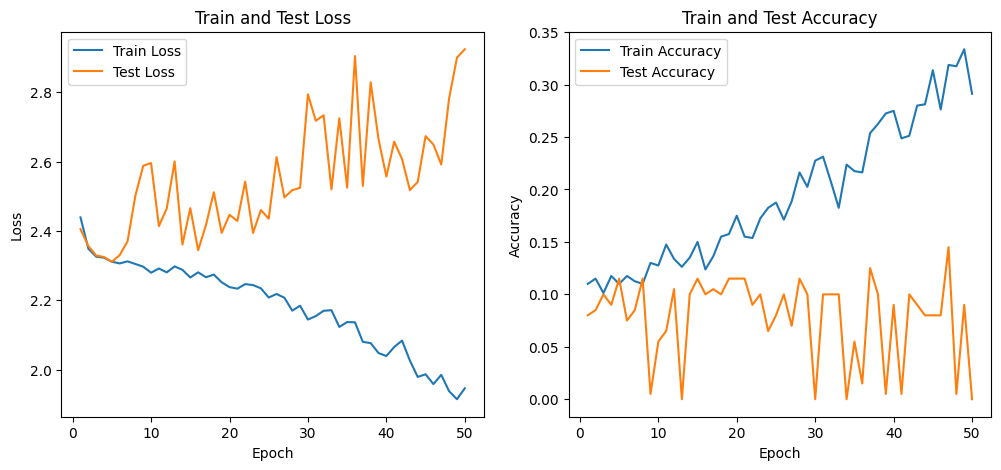

In [74]:
print(device)

num_epochs = 50

hidden_dims = [256, 512, 256, 128, 64, 32, 16]
model = CustomLSTM(input_dim=240, hidden_dims=hidden_dims, output_dim=11, dropout_rate=0.5)

optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

def calculate_accuracy(y_pred, y_true):
    predicted = torch.argmax(y_pred, 1)
    correct = (predicted == y_true).float().sum()
    return correct.item()  

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_correct = 0
    all_labels = []
    all_preds = []

    for data in train_loader:
        x, y = data
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        out = model(x)
        loss = criterion(out, y.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += calculate_accuracy(out, y)
        all_labels.extend(y.cpu().numpy())
        all_preds.extend(torch.argmax(out, 1).cpu().numpy())

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    train_accuracy = total_correct / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)

    # train_confusion_matrix = confusion_matrix(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}, Train Accuracy: {train_accuracy}")
    # print("Train Confusion Matrix:\n", train_confusion_matrix)

    # Validation
    model.eval()
    test_loss = 0
    total_correct = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for data in test_loader:
            x, y  = data
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            loss = criterion(out, y.long())
            test_loss += loss.item()
            total_correct += calculate_accuracy(out, y)
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(torch.argmax(out, 1).cpu().numpy())

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    test_accuracy = total_correct / len(test_loader.dataset)
    test_accuracies.append(test_accuracy)

    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for train and test losses
ax1.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
ax1.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train and Test Loss')
ax1.legend()

# Plot for train and test accuracies
ax2.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
ax2.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train and Test Accuracy')
ax2.legend()

plt.show()
